In [ ]:
from torch.utils.data import Dataset, DataLoader


In [ ]:
def download_dataset():
  # set up kaggle api and credentials
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # download the dataset
  !kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
  #unzip
  !mkdir diabetic-retinopathy-resized
  !unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
  !mv ./* diabetic-retinopathy-resized

In [ ]:
import os
dataset_dir_exist = os.path.isdir('diabetic-retinopathy-resized')
if not dataset_dir_exist:
  print('downloading dataset')
  download_dataset()


downloading dataset


Streaming output truncated to the last 5000 lines.
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflati

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
pd.read_csv("./diabetic-retinopathy-resized/trainLabels.csv")['level'].unique()

# classes

array([0, 1, 2, 4, 3])

In [ ]:
cropped = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")[:5000]

In [ ]:
cropped.iloc[0]

Unnamed: 0            0
Unnamed: 0.1          0
image           10_left
level                 0
Name: 0, dtype: object

In [ ]:
image_names = os.listdir("./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/")
image_names.sort()
image_names[:5]

['10003_left.jpeg',
 '10003_right.jpeg',
 '10007_left.jpeg',
 '10007_right.jpeg',
 '10009_left.jpeg']

In [ ]:
images_path = "./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
img_path = os.path.join(images_path, cropped.iloc[3500].image+".jpeg")
img_path

'./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/4380_left.jpeg'

(1024, 1024)

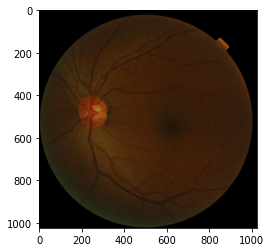

In [ ]:
img = Image.open(img_path)

plt.imshow(img)

img.size

In [ ]:
import torchvision.transforms as transforms
my_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

In [ ]:
import torch

class retinaDataset(Dataset):
    def __init__(self, imagepath="./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped", total=None,transform=my_transform):
        self.df = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")
        
        if (total is not None):
            self.df = self.df[:total]
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        img = Image.open(img_path)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)


In [ ]:
# train with all images
train_dataset = retinaDataset(total=None)

(torch.Size([3, 299, 299]), tensor(0), 35108)

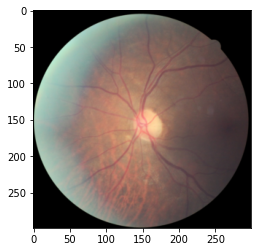

In [ ]:
img, label = train_dataset[0]

plt.imshow(img.permute(1,2,0))
img.shape, label, train_dataset.__len__()

In [ ]:
num_classes = 5
learning_rate = 1e-4
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision.models import inception_v3

model = inception_v3(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = torch.nn.Linear(in_features=2048, out_features=5, bias=True)
model.aux_logits = False
model = model.to(device=device)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 32

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from tqdm import tqdm

for epoch in range(num_epochs):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        optimizer.zero_grad()
        
        loss = loss_criterion(score, target)
        loss.backward()
        
        optimizer.step()
    
    print(f"for epoch {epoch}, loss : {loss}")
    

100%|██████████| 1098/1098 [14:44<00:00,  1.24it/s]


for epoch 0, loss : 0.9021434783935547


100%|██████████| 1098/1098 [14:22<00:00,  1.27it/s]


for epoch 1, loss : 1.1688218116760254


100%|██████████| 1098/1098 [14:11<00:00,  1.29it/s]


for epoch 2, loss : 0.31149399280548096


100%|██████████| 1098/1098 [14:36<00:00,  1.25it/s]


for epoch 3, loss : 1.240857481956482


 25%|██▍       | 274/1098 [03:36<10:51,  1.27it/s]


KeyboardInterrupt: ignored

In [ ]:
def check_accuracy(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")

In [ ]:
check_accuracy(model, train_dataloader)

100%|██████████| 1098/1098 [14:02<00:00,  1.30it/s]

out of 35108 , total correct: 25973 with an accuracy of 73.9802896976471


In [ ]:
image = Image.open("../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10007_right.jpeg")

img = my_transform(image).unsqueeze(0)

score = model(img)

_, predictions = score.max(1)

plt.imshow(image)

print("predicted: ", predictions)

df = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels_cropped.csv")

# print(df[image][:5])
# print(df.loc[df[image]=="10_left"].level)
print("actual: ", df.loc[df['image'].isin(['10007_right'])].level)


In [ ]:
def check_accuracy_simple(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            print(predictions)
            break
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")

In [ ]:
check_accuracy_simple(model, train_dataloader)

  0%|          | 0/1098 [00:01<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


ZeroDivisionError: ignored